# Лабораторная работа № 4. Латентное размещение Дирихле

In [ ]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving wiki_movie_plots_deduped.csv to wiki_movie_plots_deduped.csv


In [ ]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [ ]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

The movie follows brilliant ventriloquist "The Great Gabbo" (Stroheim), who increasingly uses his dummy "Otto" as his only means of self-expression—an artist driven insane by his work.
Gabbo's gimmick is his astonishing ability to make Otto talk—and even sing—while Gabbo himself smokes, drinks and eats. Gabbo's girlfriend and assistant Mary (Betty Compson) loves him, but is driven to leave him by his megalomania, superstitions, irritability, and inability to express any human emotion without using Otto as an intermediary. In Otto's voice Gabbo accepts the blame for Mary's leaving and recounts all the things she did for him, but as Gabbo he denies his feelings and tells the dummy to shut up.
Two years later, Gabbo has become a nationally renowned ventriloquist. He is revered for his talent even as he is ridiculed for his eccentricity: he takes Otto with him everywhere he goes, even dining out with him, providing much entertainment to the restaurant patrons. Despite his success he contin

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [ ]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [ ]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [ ]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [ ]:
print(data.sample(1).values[0])

tip carter teenaged daughter linda is upset because her alcoholic father is drinking inside a bar and ha a heart condition tip a widower and a former newspaper crime reporter moved to mexico many year ago without explanation trying to make amends for his behavior tip get in touch with dave brady a crime novelist he admires dave explains to his best friend los angeles district attorney dan mccracken that he intends to travel to mexico to see tip in person mccracken is aware of the circumstance that tip wa a suspect in a murder case but skipped the country instead tip explains to dave that he wa about to expose the killer identity year ago when gangster caruthers and gato forced him to flee to mexico by threatening his daughter life he is now ready to return linda to the land of her birth and face the consequence but when a hired assassin called cookie take a shot at him tip realizes that the gangster are after him taking back road toward nogales in a car dave and the morgan are pursued 

Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

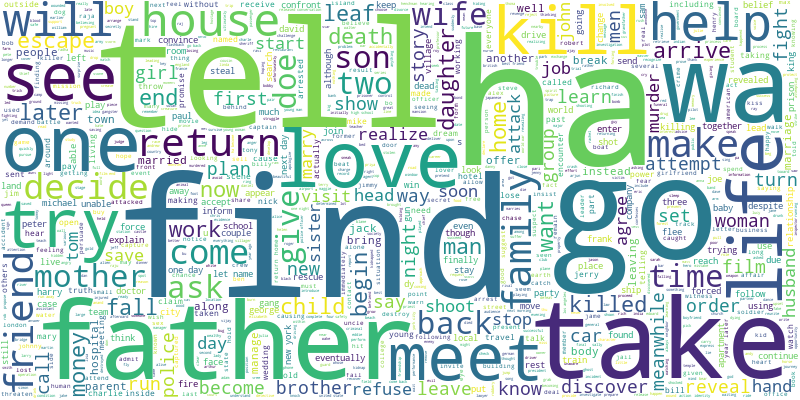

In [ ]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


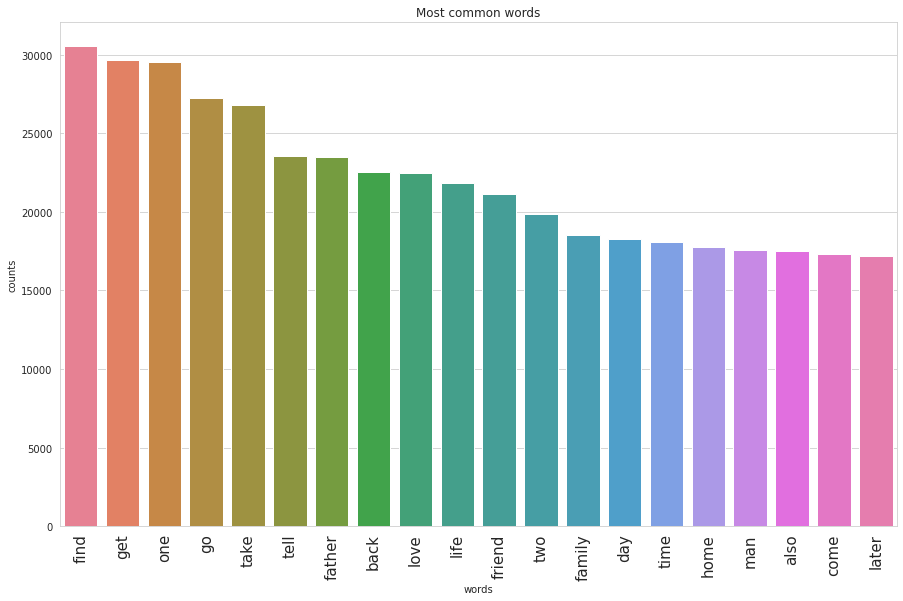

In [ ]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [ ]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
### YOUR CODE HERE
from sklearn.decomposition import LatentDirichletAllocation
model = LatentDirichletAllocation()
transformed_data = model.fit_transform(count_data)

Получим в итоге распределение тем по документам. По умолчанию число тем в данной модели равно 10. Выведем топ-20 слов.

In [ ]:
print_topics(count_vectorizer, model.components_, 20)


Topic #0
david find nick mary johnny charlie house go tell police woman home man take murder one death richard wife try

Topic #1
find one father child mother house tell life death peter school see home body return later day take time go

Topic #2
kill escape find one back group take attack ship two fight earth power help killed attempt return however human king

Topic #3
love get father come family friend life son go one take find day also daughter house meet police mother brother

Topic #4
war team army harry german american soldier captain men british one take order officer game ship return new back force

Topic #5
paul adam scott susan dave jason annie find bond luke jesse kill one take get tell family back go vincent

Topic #6
film life story jack family one young year also time wife new woman man two son love becomes father friend

Topic #7
tom get joe go jerry money back car find tell take mike police try jim see one michael bill run

Topic #8
police kill town gang men find tak

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


В целом по найденным наиболее частым словам тем сложно однозначно определить конкретные темы, присутствует общая лексика, но в целом приблизительно темы определить можно: фильмы ужасов/криминальные боевики, мелодрамы, детское/подростковое кино, полицейские боевики, семейное кино, военные фильмы, фантастика и т. д.

Рассмотрим распредление слов в темах в целом, рассмотрим число слов с различной встречаемостью в темах. График встречаемости для каждого из слов словаря в наглядном и интерпретируемом виде построить затруднительно в силу большого объема словаря и малых значений встречаемости.

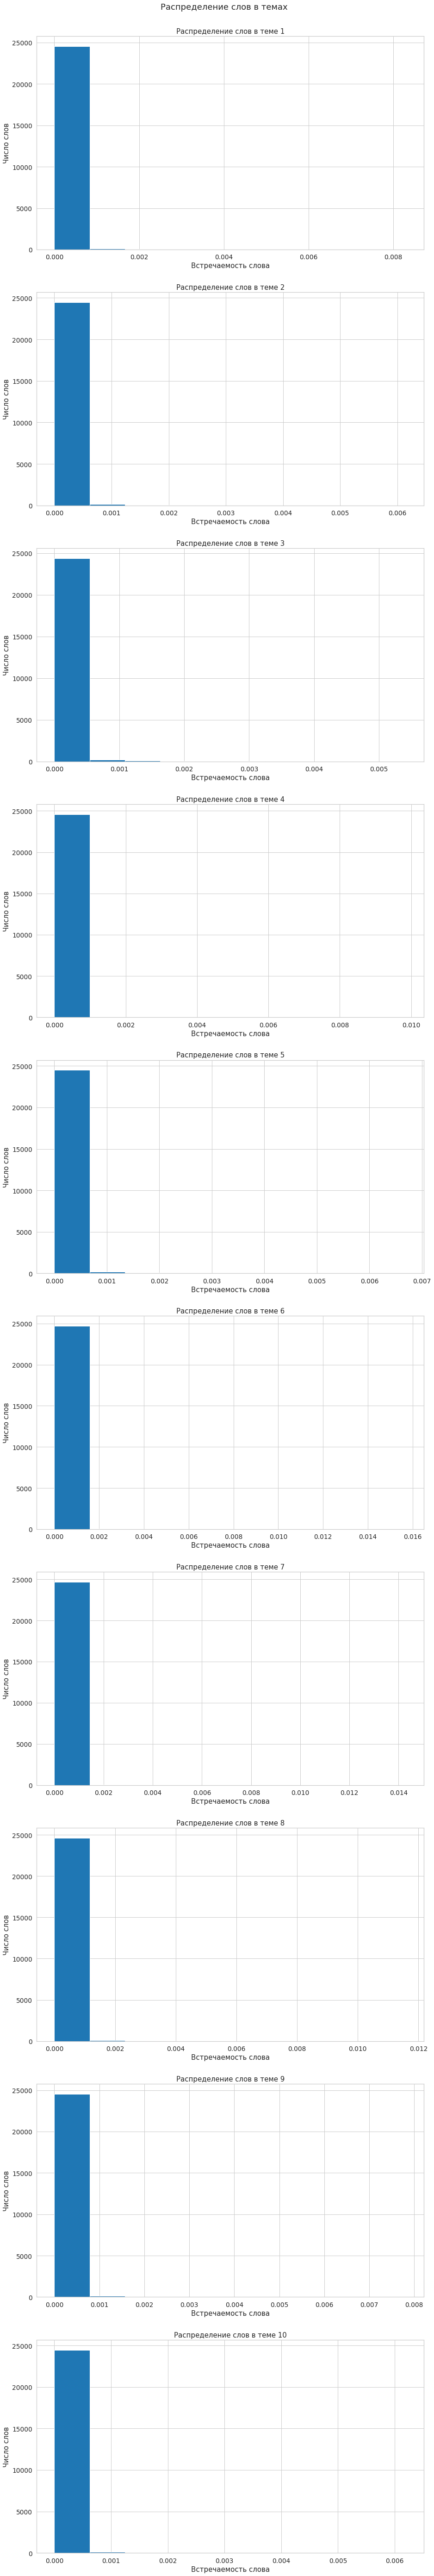

In [ ]:
fig, axes = plt.subplots(10, 1, figsize=(15, 100))
themes_distribution = model.components_ / np.sum(model.components_, axis=1, keepdims=True)
plt.suptitle('Распределение слов в темах', y=0.89)
for num, ax in enumerate(axes):
    ax.hist(themes_distribution[num, :])
    ax.set_title(f'Распределение слов в теме {num+1}')
    ax.set_xlabel('Встречаемость слова')
    ax.set_ylabel('Число слов')


Во всех темах слова в целом распределены достаточно равномерно, все они имеют достаточно низкое значение встречаемости, в основном в силу довольно большого размера словаря и больших размеров текстов.

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

Рассмотрим встречаемость тем в документах корпуса.

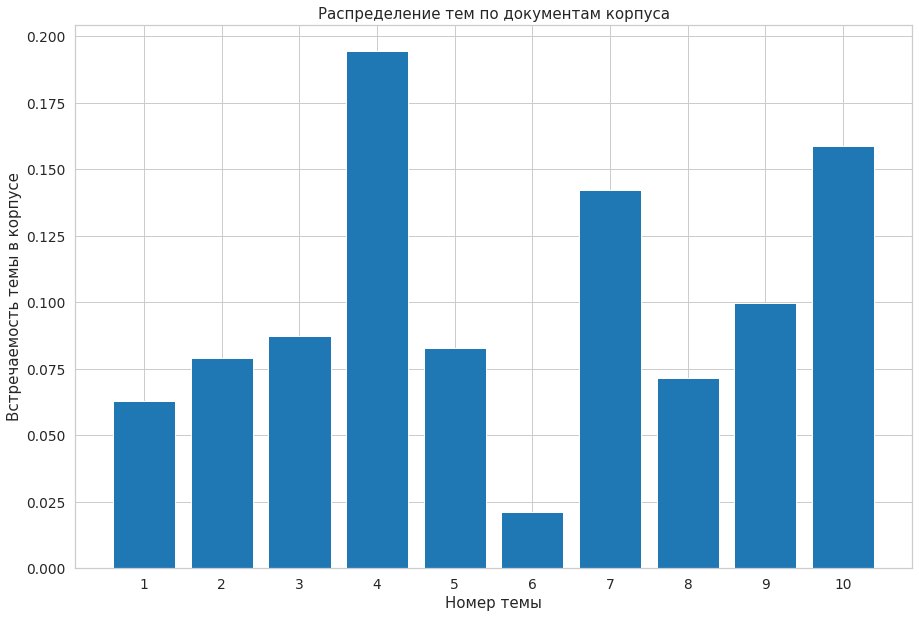

In [ ]:
### YOUR CODE HERE
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.bar(np.arange(1, 11), transformed_data.mean(axis=0))
plt.title('Распределение тем по документам корпуса')
plt.xlabel('Номер темы')
plt.ylabel('Встречаемость темы в корпусе')
plt.xticks(np.arange(1, 11))
plt.grid(True)

Чаще всего встречаются темы 4, 7, 10, почти вдвое чаще среднего. Менее всего представлена тема 6. Остальные темы распределены схожим образом.

Рассмотрим, как распределена каждая из тем по корпусу.

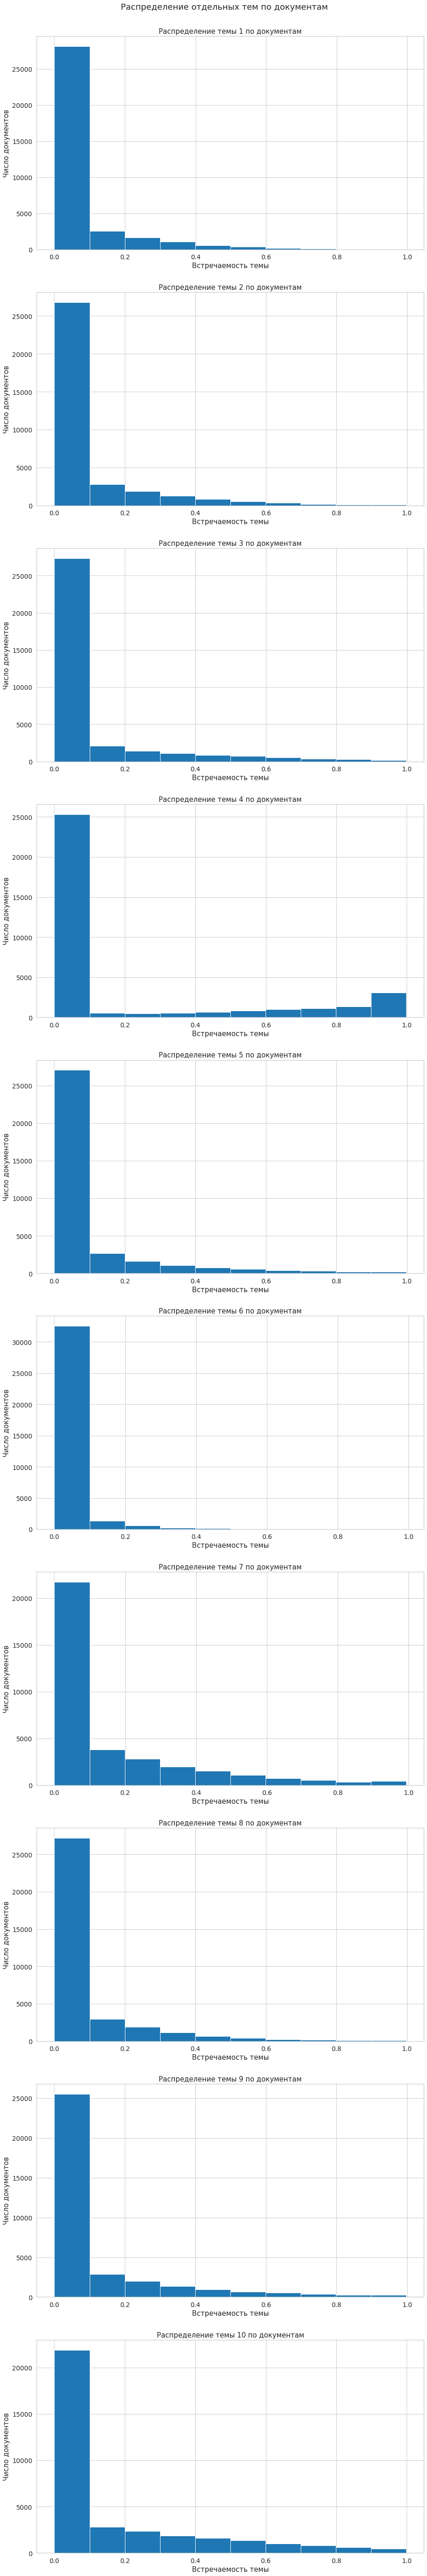

In [ ]:
fig, axes = plt.subplots(10, 1, figsize=(15, 100))
plt.suptitle('Распределение отдельных тем по документам', y=0.89)
for num, ax in enumerate(axes):
    ax.hist(transformed_data[:, num])
    ax.set_title(f'Распределение темы {num+1} по документам')
    ax.set_xlabel('Встречаемость темы')
    ax.set_ylabel('Число документов')
    

В целом в большинстве документов темы имеют низкую встречаемость, близкую к нулю, т. е. можно сказать, что темы не так ярко выражены в текстах корпуса. Средняя встречаемость близка к нулю, распределение встречаемости сосредоточено около 0, дисперсия достаточно мала. С ростом встречаемости заметно уменьшается число соответствующих документов для почти всех тем, однако для темы 4 наоборот заметно небольшое возрастание, выделяется группа документов, где эта тема встречается с вероятностью 1. Встречаемость, отличную от нулевой или околонулевой темы в целом имеют в очень небольшом числе текстов. На фоне остальных в наибольшем числе документов встречается тема 4, можно также выделить темы 7 и 10. Тема 6 представлена в корпусе менее всего. Таким образом, среди всех выделяются темы 4 и 10 как две наиболее встречаемые. Тема 4 ярко выражена в отдельной группе текстов, где ее встречаемость равна 1, тема 10 в целом достаточно распространена в корпусе, в большом числе текстов ее встречаемость существенно отлична от 0.

Рассмотрим встречаемость наиболее частых слов корпуса в темах. Рассмотрим сами слова.

In [ ]:
vocab = count_vectorizer.vocabulary_
words_vocab = {token: word for word, token in vocab.items()}
words_freq = np.sum(count_data.toarray(), axis=0)
sorted_words_idx = np.argsort(words_freq)[::-1]
sorted_words_occurencies = words_freq[sorted_words_idx] / np.sum(words_freq)
corpus_top = [words_vocab[idx] for idx in sorted_words_idx[:10]]
print('Top 10 of corpus words:')
print(*corpus_top)

Top 10 of corpus words:
find get one go take tell father back love life


Результаты в целом соответствуют коллекции текстов сценариев фильмов, слова достаточно общие, сложно сказать, что они характеризуют какие-то конкретные темы, но некоторые из них отчасти определить можно. 

Рассмотрим их встречаемость в отдельных темах.



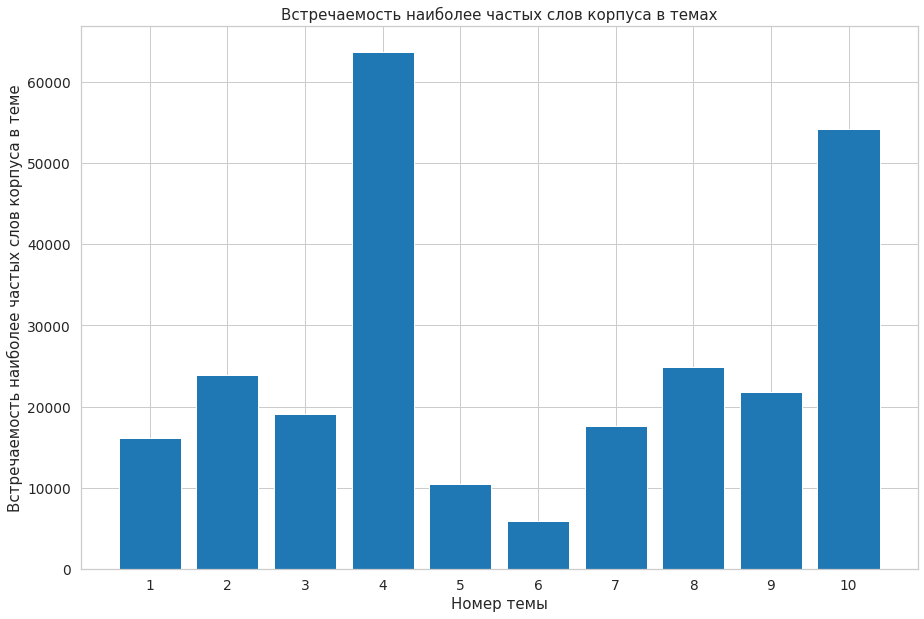

In [ ]:
plt.figure(figsize=(15, 10))
corpus_top_by_themes = model.components_[:, sorted_words_idx[:10]]
plt.bar(np.arange(1, 11), corpus_top_by_themes.sum(axis=1))
plt.xlabel('Номер темы')
plt.ylabel('Встречаемость наиболее частых слов корпуса в теме')
plt.title('Встречаемость наиболее частых слов корпуса в темах')
plt.xticks(np.arange(1, 11))
plt.grid(True)

Отмеченные ранее темы 4 и 10 действительно заметно выделяются, в них чаще всего присутствуют наиболее частые слова по всей коллекции. В остальных темах они встречаются заметно реже. В принципе можно сказать, что это согласуется со встречаемостью самих тем и найденными ранее соответствующими наиболее частыми словами тем, они во многом схожи и могут пересекаться. Вероятно это существительные и глаголы, часто используемые для описания последовательности действий/сюжета и т. д. Что касается тем с общей лексикой, то темы 4 и 10 отчасти можно назвать таковыми, в них действительно среди наиболее популярных слов выделилось много относительно нейтральных слов, которые могут использоваться в различных тематиках. Также об этом свидетельствует их встречаемость и встречаемость наиболее популярных слов корпуса в них. Однако по некоторым из топ-20 слов можно предположить, что в эти темы выделились сценарии довольно нейтральных фильмов, семейных, мелодрам или "про жизнь" в целом (слова father, mother, house, life и т. д.), поэтому выделившиеся темы могут иметь определенный смысл, а не быть просто набором общей лексики.

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

In [ ]:
### YOUR FORMULAS HERE

Запишем совместное распределение в индикаторной форме:

$p(W, t \mid \Phi, \pi)=\prod\limits_{d=1}^D \prod\limits_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}=\prod\limits_{d=1}^D \prod\limits_{k=1}^T \left( \pi_k \prod\limits_{n=1}^{N_d} \phi_{k w_{dn}}\right)^{[k=t_d]}.$

**Е-шаг:**

$q(t)=\prod\limits_{d=1}^D q(t_d)$.

$q(t_d=k)=p(t_d=k \mid w_d)=\frac{p(t_d=k, w_d)}{\sum\limits_{i=1}^Tp(t_d=i, w_d)}=\frac{\pi_k \prod\limits_{n=1}^{N_d}\phi_{kw_{dn}}}{\sum\limits_{i=1}^T\pi_i \prod\limits_{n=1}^{N_d}\phi_{iw_{dn}}}=\mu_{dk}$.

**М-шаг:**

$\mathbb{E}_{q(t)}\log p(W, t \mid \Phi, \pi)=\mathbb{E}_{q(t)}\sum\limits_{d=1}^D \sum\limits_{k=1}^T [k=t_d] \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}\right)=\\
= \sum\limits_{d=1}^D \sum\limits_{k=1}^T \mathbb{E}_{q(t_d=k)}[k=t_d] \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}\right) =\\
= \sum\limits_{d=1}^D \sum\limits_{k=1}^T q(t_d=k) \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}\right)=\\
= \sum\limits_{d=1}^D \sum\limits_{k=1}^T \mu_{dk} \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}\right)\rightarrow \max_{\Phi, \pi}.$

**Формулы для $\pi$**:

Для удобства рассмотрим только части оптимизируемого функционала, зависящие от $\pi$, а также учтем условия задачи:

$\sum\limits_{d=1}^D \sum\limits_{k=1}^T \mu_{dk} \log \pi_k \rightarrow \max_{\pi}, \quad \quad \sum\limits_{k=1}^T \pi_k = 1.$

Запишем функцию Лагранжа:

$L=\sum\limits_{d=1}^D\sum\limits_{k=1}^T \mu_{dk} \log \pi_k - \lambda \left( \sum\limits_{k=1}^T \pi_k - 1\right).$

$\frac{\partial L}{\partial \pi_k}=\sum\limits_{d=1}^D \frac{\mu_{dk}}{\pi_k}-\lambda=0 \Rightarrow \pi_k=\frac{\sum\limits_{d=1}^D \mu_{dk}}{\lambda} \Rightarrow \sum\limits_{k=1}^T \pi_k = \frac{\sum\limits_{k=1}^T \sum\limits_{d=1}^D \mu_{dk}}{\lambda}=1 \Rightarrow \lambda = \sum\limits_{d=1}^D \sum\limits_{k=1}^T \mu_{dk}.$

Заметим, что $\sum\limits_{k=1}^T \mu_{dk}=\sum\limits_{k=1}^T q(t_d=k)=1 \Rightarrow \pi_k = \frac{\sum\limits_{d=1}^D \mu_{dk}}{D}.$

**Формулы для $\phi_{kw}$:**

$\sum\limits_{d=1}^D \sum\limits_{k=1}^T \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V \mu_{dk} [w_{dn}=w_i] \log \phi_{kw} \rightarrow \max_{\Phi}, \quad \quad \sum\limits_{i=1}^V \phi_{kw_i}=1.$

Запишем функцию Лагранжа для задачи:

$L=\sum\limits_{d=1}^D \sum\limits_{k=1}^T \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V \mu_{dk} [w_{dn}=w_i] \log \phi_{kw}-\lambda \left( \sum\limits_{i=1}^V \phi_{kw_i} - 1\right).$

$\frac{\partial L}{\partial \phi_{kw_i}}=\sum\limits_{d=1}^D \sum\limits_{n=1}^{N_d}\frac{\mu_{dk}[w_{dn}=w_i]}{\phi_{kw_i}}-\lambda=0 \Rightarrow \phi_{kw_i}=\frac{\sum\limits_{d=1}^D \sum\limits_{n=1}^{N_d}\mu_{dk}[w_{dk}=w_i]}{\lambda}.$

$\sum\limits_{i=1}^V \phi_{kw_i}=\frac{\sum\limits_{d=1}^D \sum\limits_{n=1}^{N_d} \mu_{dk} \sum\limits_{i=1}^V [w_{dk}=w_i]}{\lambda}=1 \Rightarrow \lambda=\sum\limits_{d=1}^D \sum\limits_{n=1}^{N_d} \mu_{dk} \sum\limits_{i=1}^V [w_{dk}=w_i]$.

$\sum\limits_{i=1}^v [w_{dk}=w_i]=1 \Rightarrow \phi_{kw_i}=\frac{\sum\limits_{d=1}^D \sum\limits_{n=1}^{N_d}\mu_{dk} [w_{dn}=w_i]}{\sum\limits_{d=1}^D N_d \mu_{dk}}.$

**Формулы для ELBO:**

$ELBO=\mathcal{L}(q, \Phi, \pi)=\mathbb{E}_{q(t)}\log \frac{p(W, t \mid \Phi, \pi)}{q(t)}=\mathbb{E}_{q(t)} \log p(W, t \mid \Phi, \pi) - \mathbb{E}_{q(t)} \log q(t)=\\=\sum\limits_{d=1}^D \sum\limits_{k=1}^T \mu_{dk} \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}-\log q(t_d=k)\right)=\\=\sum\limits_{d=1}^D \sum\limits_{k=1}^T \mu_{dk} \left( \log \pi_k + \sum\limits_{n=1}^{N_d} \sum\limits_{i=1}^V[w_{dn}=w_i] \log \phi_{kw_i}-\log \mu_{dk}\right).$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [ ]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        ### YOUR CODE HERE ###
        # Use bow in scipy sparse format
        Nd = bow.shape[0]
        if self.mu is None:
            self.mu = np.zeros((Nd, self.n_topics))
        log_phi = np.log(self.phi + self.epsilon)
        self.mu = bow * log_phi.T
        self.mu += np.log(self.pi + self.epsilon)
        self.mu = np.exp(self.mu - np.max(self.mu, axis=1, keepdims=True))
        self.mu /= np.sum(self.mu, axis=1, keepdims=True)

        
    def _m_step(self, bow):
        ### YOUR CODE HERE ###
        # Use bow in scipy sparse format
        Nd = bow.shape[0]
        self.pi = np.sum(self.mu, axis=0) / Nd
        self.phi = (bow.T * self.mu).T
        self.phi /= np.sum(self.phi, axis=1, keepdims=True)
        
    def _count_elbo(self, bow):
        # Use bow in scipy sparse format
        log_prod = np.zeros(self.mu.shape)
        log_phi = np.log(self.phi + self.epsilon)
        log_prod = bow * log_phi.T
        elbo = np.sum(self.mu * (np.log(self.pi + self.epsilon) + log_prod - np.log(self.mu + self.epsilon)))
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

По аналогии спредыдущей моделью также рассмотрим 10 тем.

In [ ]:
### YOUR CODE HERE ###
model = SimpleLDA(n_topics=10)
model.fit(count_data)


0:
 elbo: -56065092.02078027
 increase: inf

1:
 elbo: -55840256.94486066
 increase: 224835.07591961324

2:
 elbo: -55632856.83710889
 increase: 207400.1077517718

3:
 elbo: -55464652.28860747
 increase: 168204.54850141704

4:
 elbo: -55316319.97597385
 increase: 148332.3126336187

5:
 elbo: -55191951.039503105
 increase: 124368.936470747

6:
 elbo: -55116595.18123015
 increase: 75355.85827295482

7:
 elbo: -55078901.059105396
 increase: 37694.12212475389

8:
 elbo: -55058854.61324397
 increase: 20046.445861428976

9:
 elbo: -55044418.48909286
 increase: 14436.12415111065

10:
 elbo: -55032733.7966137
 increase: 11684.692479155958

11:
 elbo: -55024052.46753852
 increase: 8681.329075179994

12:
 elbo: -55017057.72405921
 increase: 6994.743479311466

13:
 elbo: -55012618.59888663
 increase: 4439.125172577798

14:
 elbo: -55007714.50595962
 increase: 4904.092927008867

15:
 elbo: -55004939.20132544
 increase: 2775.3046341836452

16:
 elbo: -55001817.09826194
 increase: 3122.103063501417

Выведем найденные темы.

In [ ]:
print_topics(count_vectorizer, model.phi, 20)


Topic #0
one kill find take two back fight later however time escape also help police return life go killed tell year

Topic #1
find go police tell get one house kill take car back two man home later see return try money father

Topic #2
get love one father go life film family village take school friend find day come back girl story tell make

Topic #3
get love father life one friend family find go come take police day also meet son tell house mother kill

Topic #4
find one take back return tell go kill father two life time king get death escape man help see later

Topic #5
go one find tell life get father friend take new home mother family love time back day film two make

Topic #6
love tom get jerry son father come daughter take family village house go life brother one fall rao also mother

Topic #7
one find take back go two escape get kill new return tell time police later killed men help make group

Topic #8
get love find go take one tell new man back father return two money frien

В отличие от стандартного LDA среди наиболее популярных слов в темах присутствует намного больше слов общей лексики (в основном одних и тех же довольно общих глаголов вроде get, tell, take, find и т. п.), присутствует много похожих и повторяющихся слов. Темы иногда чуть менее интерпретируемы, определить их порой сложнее, чем в случае классической модели, но в некоторых случаях это можно сделать приблизительно. Общий набор тем в целом совпадает с обычным LDA.


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

Обучим упрощенный LDA со словарем, составленным указанным в задании способом.

In [ ]:
### YOUR CODE HERE ###

count_vectorizer_filtered = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.1)
count_data_filtered = count_vectorizer_filtered.fit_transform(data.values)

In [ ]:
model = SimpleLDA(n_topics=10)
model.fit(count_data_filtered)


0:
 elbo: -43538814.89388233
 increase: inf

1:
 elbo: -43364328.66814312
 increase: 174486.2257392034

2:
 elbo: -43227187.87464118
 increase: 137140.79350194335

3:
 elbo: -43097260.37109241
 increase: 129927.50354877114

4:
 elbo: -42980920.19806855
 increase: 116340.17302385718

5:
 elbo: -42891145.795350425
 increase: 89774.40271812677

6:
 elbo: -42815260.6235375
 increase: 75885.17181292176

7:
 elbo: -42750971.31174624
 increase: 64289.31179126352

8:
 elbo: -42710325.15827875
 increase: 40646.15346749127

9:
 elbo: -42686919.07013921
 increase: 23406.088139541447

10:
 elbo: -42667869.94138603
 increase: 19049.12875317782

11:
 elbo: -42653325.50229606
 increase: 14544.4390899688

12:
 elbo: -42642841.37723896
 increase: 10484.12505710125

13:
 elbo: -42635043.62892695
 increase: 7797.748312011361

14:
 elbo: -42628289.47748574
 increase: 6754.151441209018

15:
 elbo: -42619948.637901135
 increase: 8340.839584603906

16:
 elbo: -42615014.42652692
 increase: 4934.211374215782


In [ ]:
print_topics(count_vectorizer_filtered, model.phi, 20)


Topic #0
king gang village team minister krishna arjun member terrorist leader lord india student army ravi movie power case surya hospital

Topic #1
village raja rao raju wedding radha college rich karthik movie priya lakshmi villager ravi rest person form doctor hospital mohan

Topic #2
tom jerry bug king cat harry dog sam castle face chase alice dracula charlie door mouse appears inside spike arthur

Topic #3
king master peter ben battle max power dragon human village long team adam li fire gang us game student sword

Topic #4
human team alien creature ship jack power john george island water fire earth max ben rescue inside boat appears discover

Topic #5
vijay raj singh village ravi ajay kumar raja college arjun hospital ram movie wedding anand khan rahul inspector truth karan

Topic #6
war ship german army soldier captain american crew british agent mission island battle japanese john earth general rescue fire team

Topic #7
jack david michael john nick joe paul drive sex hospit

Среди наиболее частых слов в темах почти полностью отсутствуют глаголы, присутствуют преимущественно существительные. В некоторых случаях интерпретируемость тем стала хуже, например, для тем, схожих с мелодрамами/сериалами и т. п., среди самых популярных слов встречаются в основном имена, хотя по остальным словам все же можно приближенно понять тему. В некоторых же случаях темы наоборот детализировались и стали сильнее выделяться, например, появились, судя по всему, темы Второй мировой войны и фэнтези, конкретизируются детали сюжета (упоминание мест действия, предметов, должностей или профессий, присутствие подобия последовательности событий) и его структура в целом. Темы в целом все так же можно понять из полученных слов. В общем можно сказть, что отсев общей лексики действительно позволил выделить более конкретные и детализированные темы, и лучше стали учитываться существительные, описывающие ключевые "сущности" и характеризующие темы и содержание текстов. Общий пул и тематика сценариев в целом осталась той же и схожа со случаем классической модели и упрощенной модели с полным словарем.

В целом упрощенная версия LDA оказалась более чувствительной к общей лексике, чем стандартная реализация. Т. к. в упрощенной версии мы относим документы к одной конкретной теме, то туда попадут и все их слова, а в документах естественно присутствует большое количество общей лексики, и она таким образом тоже попадет в темы, и получится, что она будет присутствовать во всех темах. В классической версии используется распределение тем вместо одной фиксированной, и это позволит более качественно определить принадлежность документов темам и выделить общую лексику в отдельную тему, а не позволить ей смешаться со всеми сразу, что повысит качество работы алгоритма и снизит чувствительность к общеупотребительным словам.